C:\Users\terry\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead


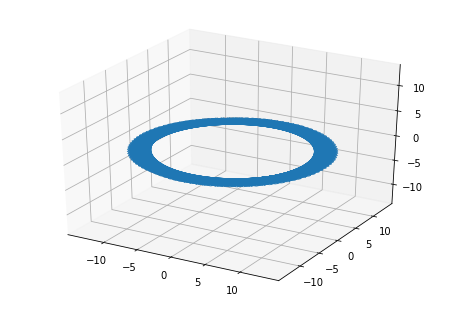

saved tri16.stl


In [32]:
import os
import math
import numpy as np
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

def reuleaux(az, rad, k):
    """A torus with Reuleaux Triangle cross-section: See https://en.wikipedia.org/wiki/Reuleaux_triangle.
    
    Args:
        az: azimuth: angle (radians) sweeping round major axis.
        rad: [-pi/3,pi/3] minor axis radians sweeps round one side of triangle on minor axis.
        k: 0-2 side number of triangle"""
    major_radius = 14.0 # mm
    minor_radius = 3.0 # mm
    z_scale = 0.6 # ratio of z height to minor axis diameter
    
    cosr = math.cos(rad)
    rot = az*2/3
    use_reuleaux = False
    if use_reuleaux:
        # Use Polar equation of a circle from https://en.wikipedia.org/wiki/Polar_coordinate_system#Circle
        # R=1, r0=1/sqrt(3) (2/3 height of unit sided equilateral triangle, offset of centre of reuleaux arc)
        r = (math.sqrt(4.0/3.0*cosr*cosr + 8.0/3.0) - 2.0/math.sqrt(3.0)*cosr)/2.0 
        def cos_deg(d):
            return math.cos(d/180*math.pi)
        degrees = (rot/math.pi*180+30)%120-30
        if degrees<30:
            r0 = 1-cos_deg(degrees)/math.sqrt(3.0)
        else:
            r0 = cos_deg(degrees-60)/math.sqrt(3.0)
    else:
        # or triange cross-section:
        r = math.cos(math.pi/3)/math.cos(rad)/3.0
        r0 = 0
    th = rad + k*math.pi*2/3 + rot  #twist it!
    reuleaux_factor = r * math.cos(th) - r0 - 0.5;
    #based on parametric equation of a torus
    full_radius = major_radius + minor_radius * reuleaux_factor;
    x = math.sin(-az) * full_radius
    y = math.cos(-az) * full_radius
    z = r * math.sin(th) * z_scale
    return np.array([x, y, z])

shape = [100,20,3,2]  # [azimuth_steps, minor_theta_steps, triangle_sides, from/to points]
data = np.zeros(shape, dtype=mesh.Mesh.dtype)
for i in range(shape[0]):
    az = i / 100.0 * math.pi*2 
    for j in range(shape[1]):
        rad1 = (j / (shape[1]/2.0) - 1) * math.pi/3
        rad2 = ((j+1) / (shape[1]/2.0) - 1) * math.pi/3
        for k in range(shape[2]):
            #quadrilateral patch of surface made of two triangles
            p0 = reuleaux(az, rad1, k)
            p1 = reuleaux(az+1, rad1, k)
            p2 = reuleaux(az+1, rad2, k)
            p3 = reuleaux(az, rad2, k)
            data[i,j,k,0][1] = [p0, p1, p2]
            data[i,j,k,1][1] = [p2, p3, p0]
            #print(data[i,j,k])
ring_mesh = mesh.Mesh(data.flatten(), remove_empty_areas=False)
#Plot it
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(ring_mesh.vectors))
scale = ring_mesh.points.flatten(-1)
axes.auto_scale_xyz(scale, scale, scale)
pyplot.show()
file_template = 'tri{}.stl'
i=0
while os.path.isfile(file_template.format(i)):
      i+=1
ring_mesh.save(file_template.format(i))
print('saved {}'.format(file_template.format(i)))